### Define imports

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import json
import os
from transformers import AutoTokenizer
import json
from reportlab.lib.pagesizes import letter, landscape
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.platypus import (
    SimpleDocTemplate, Paragraph, Spacer, PageBreak
)
from reportlab.lib.units import inch
from xml.sax.saxutils import escape

# Set global plotting style
plt.rcParams.update({
    "font.size": 11,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,

    "axes.spines.top": False,
    "axes.spines.right": False,

    "axes.grid": True,
    "grid.alpha": 0.25,
    "grid.linestyle": "--",

    "errorbar.capsize": 3,
})


### Visualize GSM8k accuracy results

No Gen Accuracies: {'no_gen_qwen3-1.7b_sol': 94.21052631578948, 'no_gen_qwen3-4b_sol': 97.90575916230367, 'no_gen_rlad_sol': 93.54838709677419}
RLAD Gen Accuracies: {'rlad_gen_qwen3-1.7b_sol': 91.39784946236558, 'rlad_gen_qwen3-4b_sol': 97.38219895287958, 'rlad_gen_rlad_sol': 95.16129032258065}
Unique Solvers: ['qwen3-1.7b_sol', 'qwen3-4b_sol', 'rlad_sol']


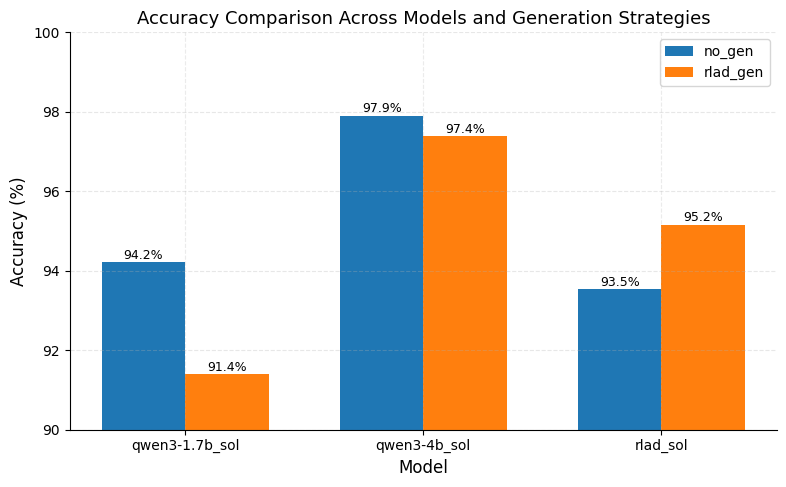

In [68]:
path_to_results = '../runs/gsm8k/summary.json'

with open(path_to_results, 'r') as f:
    results = json.load(f)

complete_results = results['aggregate']
models = list(complete_results.keys())
no_gen_acc = {
    mod: 100 * complete_results[mod]["overall"]["accuracy"] for mod in models if "no_gen" in mod
}
rlad_gen_acc = {
    mod: 100 * complete_results[mod]["overall"]["accuracy"] for mod in models if "rlad_gen" in mod
}
print("No Gen Accuracies:", no_gen_acc)
print("RLAD Gen Accuracies:", rlad_gen_acc)

# Create plots directory if it doesn't exist
os.makedirs("../plots/", exist_ok=True)

# Plot settings
unique_solvers = sorted(list({mod.replace("no_gen_", "") for mod in no_gen_acc.keys()}))

print("Unique Solvers:", unique_solvers)
x = np.arange(len(models) // 2)
width = 0.35


plt.figure(figsize=(8, 5))
bars1 = plt.bar(x - width/2, list(no_gen_acc.values()), width, label="no_gen")
bars2 = plt.bar(x + width/2, list(rlad_gen_acc.values()), width, label="rlad_gen")

# Labels & styling
plt.ylabel("Accuracy (%)")
plt.xlabel("Model")
plt.title("Accuracy Comparison Across Models and Generation Strategies")
plt.xticks(x, unique_solvers)
plt.ylim(90, 100.0)
plt.legend()

# Annotate bars with percentages
for bars in (bars1, bars2):
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.002,
            f"{height:.1f}%",
            ha="center",
            va="bottom",
            fontsize=9
        )
plt.grid(True, axis="y", alpha=0.3)
plt.savefig("../plots/gsm8k_accuracy_comparison.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()


### Calculate the average number of tokens per generated solution

In [ ]:
path_to_outputs = '../runs/gsm8k/outputs.jsonl'

# Initialize tokenizers once
toks = {}
toks["CMU-AIRe/RLAD-Sol-Gen"] = tok = AutoTokenizer.from_pretrained("CMU-AIRe/RLAD-Sol-Gen", trust_remote_code=True)
toks["Qwen/Qwen3-1.7B"] = AutoTokenizer.from_pretrained("Qwen/Qwen3-1.7B", trust_remote_code=True)
toks["Qwen/Qwen3-4B"] = AutoTokenizer.from_pretrained("Qwen/Qwen3-4B", trust_remote_code=True)

toks_counts = {}

with open('../runs/gsm8k/outputs.jsonl', 'r') as f:
    for line in f:
        ex = json.loads(line)
        model_id = ex['solver_model_id']
        pipeline = ex['pipeline']
        if pipeline not in toks_counts:
            toks_counts[pipeline] = []
        example_idxs = ex["row_idx"]
        model_output = ex['solver_output']
        n_toks = len(toks[model_id].tokenize(model_output))
        toks_counts[pipeline].append((n_toks, example_idxs))
        

### Plot GSM8k statistics on trancated responses

No Gen Truncated: {'no_gen_qwen3-1.7b_sol': 5.0, 'no_gen_qwen3-4b_sol': 4.5, 'no_gen_rlad_sol': 7.0}
RLAD Gen Truncated: {'rlad_gen_qwen3-1.7b_sol': 7.0, 'rlad_gen_qwen3-4b_sol': 4.5, 'rlad_gen_rlad_sol': 7.0}
Unique Solvers: ['qwen3-1.7b_sol', 'qwen3-4b_sol', 'rlad_sol']


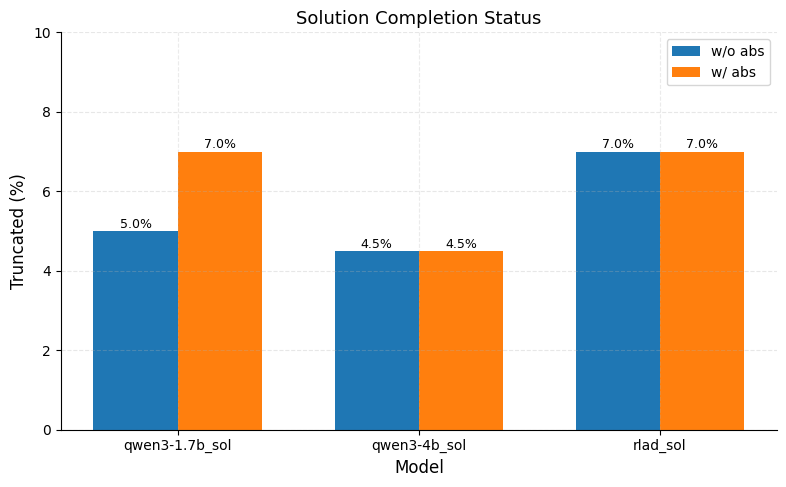

In [97]:
num_examples = results["selected"]["n_total"]

no_gen_trunc = {
    mod: 100 * (complete_results[mod]["overall"]["truncated"] + 2.0) / float(num_examples) for mod in models if "no_gen" in mod
}
rlad_gen_trunc = {
    mod: 100 * (complete_results[mod]["overall"]["truncated"] + 2.0) / float(num_examples) for mod in models if "rlad_gen" in mod
}
print("No Gen Truncated:", no_gen_trunc)
print("RLAD Gen Truncated:", rlad_gen_trunc)

# Create plots directory if it doesn't exist
os.makedirs("../plots/", exist_ok=True)

# Plot settings
unique_solvers = sorted(list({mod.replace("no_gen_", "") for mod in no_gen_trunc.keys()}))

print("Unique Solvers:", unique_solvers)
x = np.arange(len(models) // 2)
width = 0.35


plt.figure(figsize=(8, 5))
bars1 = plt.bar(x - width/2, list(no_gen_trunc.values()), width, label="w/o abs")
bars2 = plt.bar(x + width/2, list(rlad_gen_trunc.values()), width, label="w/ abs")
# Labels & styling
plt.ylabel("Truncated (%)")
plt.xlabel("Model")
plt.title(f"Solution Completion Status")
plt.xticks(x, unique_solvers)
plt.ylim(0, 10.0)
plt.legend()

# Annotate bars with percentages
for bars in (bars1, bars2):
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.002,
            f"{height:.1f}%",
            ha="center",
            va="bottom",
            fontsize=9
        )
plt.grid(True, axis="y", alpha=0.3)

plt.savefig("../plots/gsm8k_truncated_comparison.pdf", bbox_inches='tight')
plt.tight_layout()
plt.show()

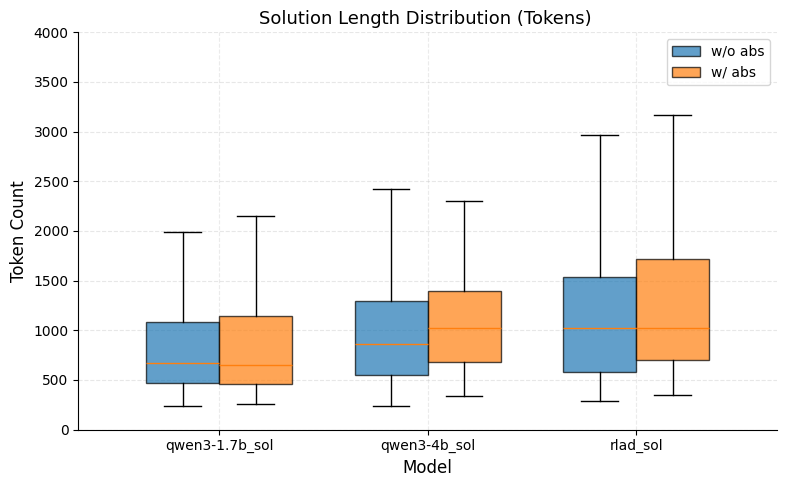

In [95]:
num_examples = results["selected"]["n_total"]

# Create plots directory if it doesn't exist
os.makedirs("../plots/", exist_ok=True)

# Consistent solver order
unique_solvers = sorted(
    mod.replace("no_gen_", "") for mod in toks_counts if "no_gen" in mod
)
x = np.arange(len(unique_solvers))
width = 0.35

plt.figure(figsize=(8, 5))

# Collect raw token counts
no_gen_data = [
    [n_toks for n_toks, _ in toks_counts[f"no_gen_{s}"]]
    for s in unique_solvers
]
rlad_data = [
    [n_toks for n_toks, _ in toks_counts[f"rlad_gen_{s}"]]
    for s in unique_solvers
]

# Box plots
bp1 = plt.boxplot(
    no_gen_data,
    positions=x - width / 2,
    widths=width,
    patch_artist=True,
    showfliers=False
)

bp2 = plt.boxplot(
    rlad_data,
    positions=x + width / 2,
    widths=width,
    patch_artist=True,
    showfliers=False
)

# Coloring (minimal, clean)
for box in bp1["boxes"]:
    box.set(facecolor="C0", alpha=0.7)
for box in bp2["boxes"]:
    box.set(facecolor="C1", alpha=0.7)

# Labels & styling
plt.ylabel("Token Count")
plt.xlabel("Model")
plt.title(
    f"Solution Length Distribution (Tokens) "
)
plt.xticks(x, unique_solvers)
plt.ylim(0, 4000)
plt.legend(
    [bp1["boxes"][0], bp2["boxes"][0]],
    ["w/o abs", "w/ abs"]
)

plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig("../plots/gsm8k_token_distribution_boxplot.pdf", bbox_inches="tight")
plt.show()

### Plot statistics on number of tokens per response

No Gen Tokens: {'no_gen_qwen3-1.7b_sol': 881.6315789473684, 'no_gen_qwen3-4b_sol': 1067.2460732984293, 'no_gen_rlad_sol': 1293.97311827957}
RLAD Gen Tokens: {'rlad_gen_qwen3-1.7b_sol': 976.1505376344086, 'rlad_gen_qwen3-4b_sol': 1173.261780104712, 'rlad_gen_rlad_sol': 1327.8387096774193}
Unique Solvers: ['qwen3-1.7b_sol', 'qwen3-4b_sol', 'rlad_sol']


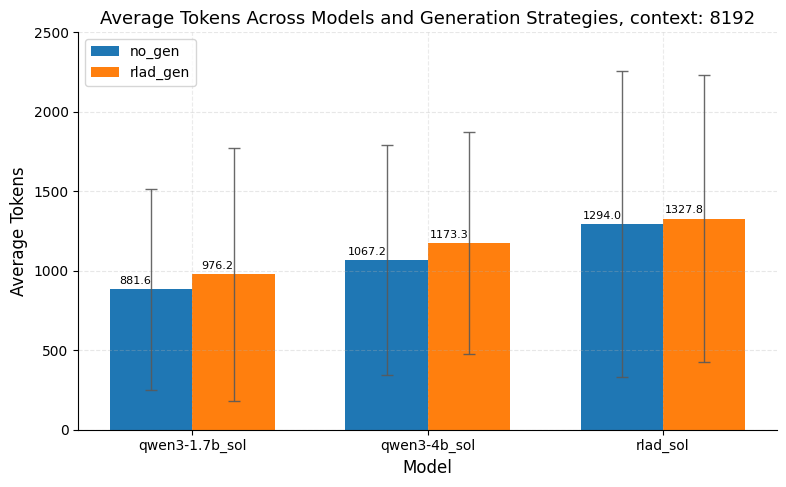

In [98]:
num_examples = results["selected"]["n_total"]

no_gen_toks = {pipe: np.mean([n_toks for n_toks, _ in toks_counts[pipe]]) for pipe in toks_counts if "no_gen" in pipe}

rlad_gen_toks = {pipe: np.mean([n_toks for n_toks, _ in toks_counts[pipe]]) for pipe in toks_counts if "rlad_gen" in pipe}

no_gen_toks_stds = {pipe: np.std([n_toks for n_toks, _ in toks_counts[pipe]]) for pipe in toks_counts if "no_gen" in pipe}

rlad_gen_toks_stds = {pipe: np.std([n_toks for n_toks, _ in toks_counts[pipe]]) for pipe in toks_counts if "rlad_gen" in pipe}


print("No Gen Tokens:", no_gen_toks)
print("RLAD Gen Tokens:", rlad_gen_toks)

# Create plots directory if it doesn't exist
os.makedirs("../plots/", exist_ok=True)

# Plot settings
unique_solvers = sorted(list({mod.replace("no_gen_", "") for mod in no_gen_toks.keys()}))

print("Unique Solvers:", unique_solvers)
x = np.arange(len(models) // 2)
width = 0.35


plt.figure(figsize=(8, 5))

error_kw = dict(
    ecolor="0.35",      
    elinewidth=1.0,
    capthick=1.0,
    alpha=0.9
)

bars1 = plt.bar(x - width/2, list(no_gen_toks.values()), width,  yerr=list(no_gen_toks_stds.values()), capsize=4, error_kw= error_kw, label="no_gen")
bars2 = plt.bar(x + width/2, list(rlad_gen_toks.values()), width, yerr=list(rlad_gen_toks_stds.values()), capsize=4, error_kw= error_kw, label="rlad_gen")   
      
# Labels & styling
plt.ylabel("Average Tokens")
plt.xlabel("Model")
plt.title(f"Average Tokens Across Models and Generation Strategies, context: {results['gen_cfg']['max_context_tokens']}")
plt.xticks(x, unique_solvers)
plt.ylim(0, 2500.0)
plt.legend()

# Annotate bars with percentages
for bars in (bars1, bars2):
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + 20,
            f"{height:.1f}",
            ha="right",
            va="bottom",
            fontsize= 8
        )
plt.grid(True, axis="y", alpha=0.3)

plt.savefig("../plots/gsm8k_average_tokens_comparison.pdf", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

### Extract results for HMMT25
* pass@k and vote acc

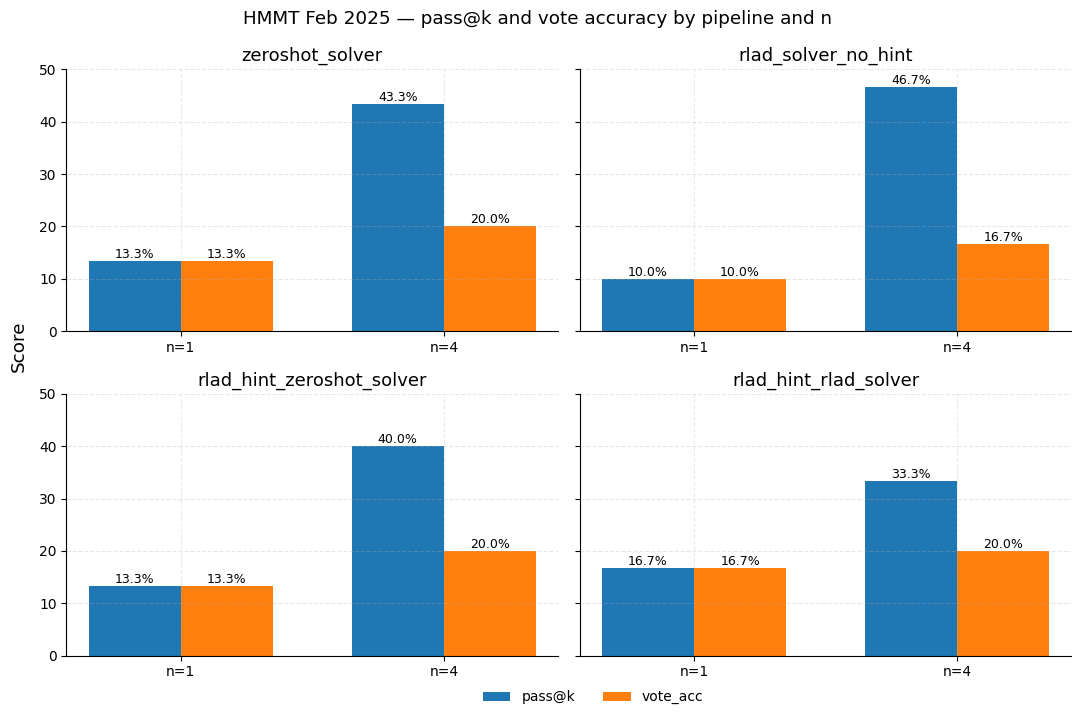

In [99]:
results_path = '../runs/hmmt25/summary.json'

with open(results_path, 'r') as f:
    results = json.load(f)


pipelines = [
    "zeroshot_solver",
    "rlad_solver_no_hint",
    "rlad_hint_zeroshot_solver",
    "rlad_hint_rlad_solver",
]

n_values = [1, 4]
metrics = ["pass_at_k", "vote_acc"]  # plot these side-by-side

fig, axes = plt.subplots(2, 2, figsize=(11, 7), sharey=True)
axes = axes.flatten()

bar_w = 0.35
x = np.arange(len(n_values))

for ax, pipe in zip(axes, pipelines):
    by_n = results["results"][pipe]["all"]["by_n"]

    # Extract metric values for n=1 and n=4 (keys are strings in your dict)
    vals = {m: [by_n[str(n)][m] for n in n_values] for m in metrics}

    ax.bar(x - bar_w/2, 100 * np.array(vals["pass_at_k"]), width=bar_w, label="pass@k")
    ax.bar(x + bar_w/2, 100 * np.array(vals["vote_acc"]),  width=bar_w, label="vote_acc")

    ax.set_title(pipe)
    ax.set_xticks(x)
    ax.set_xticklabels([f"n={n}" for n in n_values])
    ax.set_ylim(0.0, 50.0)
    ax.grid(True, axis="y", alpha=0.3)

    # annotate percentages
    for i, n in enumerate(n_values):
        ax.text(x[i] - bar_w/2, 100 * vals["pass_at_k"][i] + 0.02, f"{100 * vals['pass_at_k'][i]:.1f}%",
                ha="center", va="bottom", fontsize=9)
        ax.text(x[i] + bar_w/2, 100 * vals["vote_acc"][i] + 0.02, f"{100 * vals['vote_acc'][i]:.1f}%",
                ha="center", va="bottom", fontsize=9)

# Common labels/legend
fig.suptitle("HMMT Feb 2025 — pass@k and vote accuracy by pipeline and n", y=0.98)
# fig.supxlabel("Number of samples (n)")
fig.supylabel("Score")

# Put one legend for the whole figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=2, frameon=False, bbox_to_anchor=(0.55, -0.03))

plt.tight_layout()
plt.savefig("../plots/hmmt25_pipeline_comparison.pdf", bbox_inches='tight')
plt.show()

### Print some examples from HMMT25

In [65]:

def ptext(s: str) -> str:
    # Escape &, <, > so ReportLab doesn't treat them as tags
    s = "" if s is None else str(s)
    s = escape(s)
    # Convert newlines to <br/> after escaping
    return s.replace("\n", "<br/>")

def read_jsonl(path):
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line:
                yield json.loads(line)

def safe(x, default=""):
    return default if x is None else str(x)

def truncate(s, n=400):
    s = safe(s)
    return s if len(s) <= n else s[: n - 1] + "…"

def export_outputs_pdf(
    jsonl_path: str,
    pdf_path: str,
    max_rows: int | None = None,
    detail_pages_for: str = "incorrect",  # "incorrect" or "all"
):
    styles = getSampleStyleSheet()
    title_style = styles["Title"]
    normal = styles["BodyText"]
    
    mono_style = ParagraphStyle(
        "mono",
        parent=normal,
        fontName="Courier",
        fontSize=8.5,
        leading=10.5,
    )

    # Landscape letter looks good for wide tables
    doc = SimpleDocTemplate(
        pdf_path,
        pagesize=landscape(letter),
        leftMargin=0.5 * inch,
        rightMargin=0.5 * inch,
        topMargin=0.45 * inch,
        bottomMargin=0.5 * inch,
        title="Model Outputs Report",
    )

    elements = []

    # --- Load rows ---
    rows = []
    for ex in read_jsonl(jsonl_path):
        rows.append(ex)
        if max_rows is not None and len(rows) >= max_rows:
            break

    # --- Header ---
    elements.append(Paragraph("Model Outputs Report", title_style))
    elements.append(Paragraph(f"Source: {safe(jsonl_path)}", normal))
    elements.append(Paragraph(f"Number of Examples: {len(rows)}", normal))
    elements.append(Spacer(1, 10))

    # --- Detail pages ---
    elements.append(PageBreak())
    elements.append(Paragraph("Details", title_style))
    elements.append(Spacer(1, 8))

    for ex in rows:
        if detail_pages_for == "incorrect" and ex.get("correct", False):
            continue

        ch = ex.get("abstractions", "")[0]
        ch = ch.strip() if ch and ch.strip() else "(none)"

        gt_full = ex.get("ground_truth_answer", "")
        gt_full = gt_full.strip() if gt_full else "(none)"

        sol = ex.get("solutions", "")[0][0]
        
        sol = sol.strip() if sol else "(none)"

        elements.append(Paragraph(
            f"Question: {ptext(ex.get('row_idx'))} • "
            f"{'Correct' if ex.get('correct') else 'Incorrect'}",
            styles["Heading2"]
        ))

        elements.append(Paragraph(
            f"<b>Hint:</b> {ptext(ex.get('hint_model_id')) if ex.get('hint_model_id') else 'None'}", normal
        ))
        elements.append(Paragraph(
            f"<b>Model:</b> {ptext(ex.get('solver_model_id'))}", normal
        ))
        elements.append(Paragraph(
            f"<b>GT:</b> {ptext(ex.get('ground_truth_answer'))} "
            f"&nbsp;&nbsp; <b>Pred:</b> {ptext(ex.get('pred_extracted'))}",
            normal,
        ))

        elements.append(Spacer(1, 6))

        elements.append(Paragraph("<b>Question</b>", styles["Heading3"]))
        elements.append(Paragraph(ptext(ex.get("question", "")), normal))

        elements.append(Spacer(1, 6))
        elements.append(Paragraph("<b>Cheatsheet</b>", styles["Heading3"]))
        elements.append(Paragraph(ptext(ch), normal))

        elements.append(Spacer(1, 6))
        elements.append(Paragraph("<b>Ground Truth (full)</b>", styles["Heading3"]))
        elements.append(Paragraph(ptext(gt_full), normal))

        elements.append(Spacer(1, 6))
        elements.append(Paragraph("<b>Solver Output</b>", styles["Heading3"]))
        elements.append(Paragraph(ptext(sol), mono_style))

        elements.append(PageBreak())


    doc.build(elements)
    print(f"Wrote: {pdf_path}")

In [66]:
export_outputs_pdf(
    jsonl_path= "../runs/hmmt25/records.jsonl",
    pdf_path= "../runs/hmmt25/outputs_report.pdf",
    detail_pages_for= "all"  # "incorrect" or "all"
)

Wrote: ../runs/hmmt25/outputs_report.pdf


### HMMT25 avg and best for 4x1

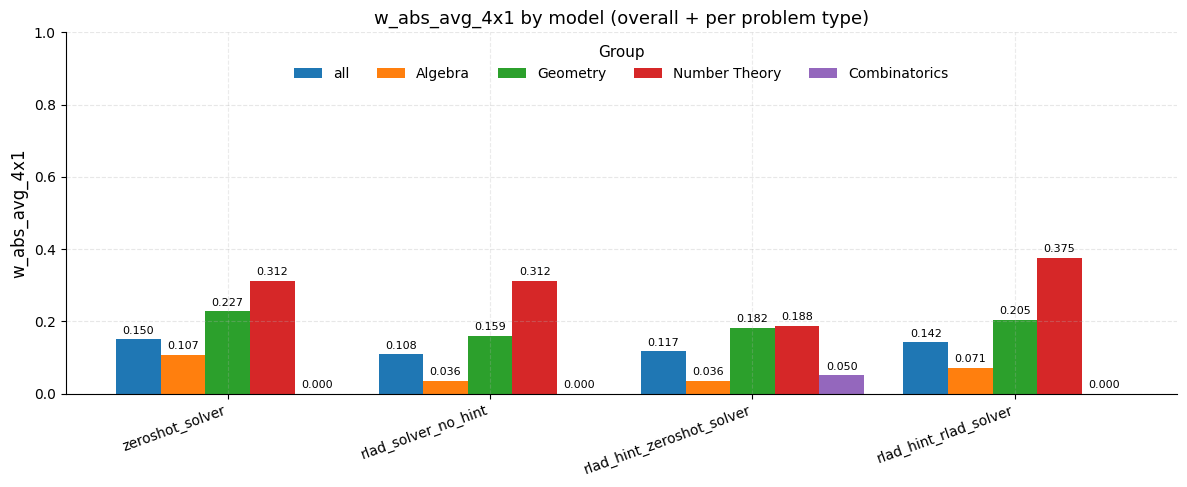

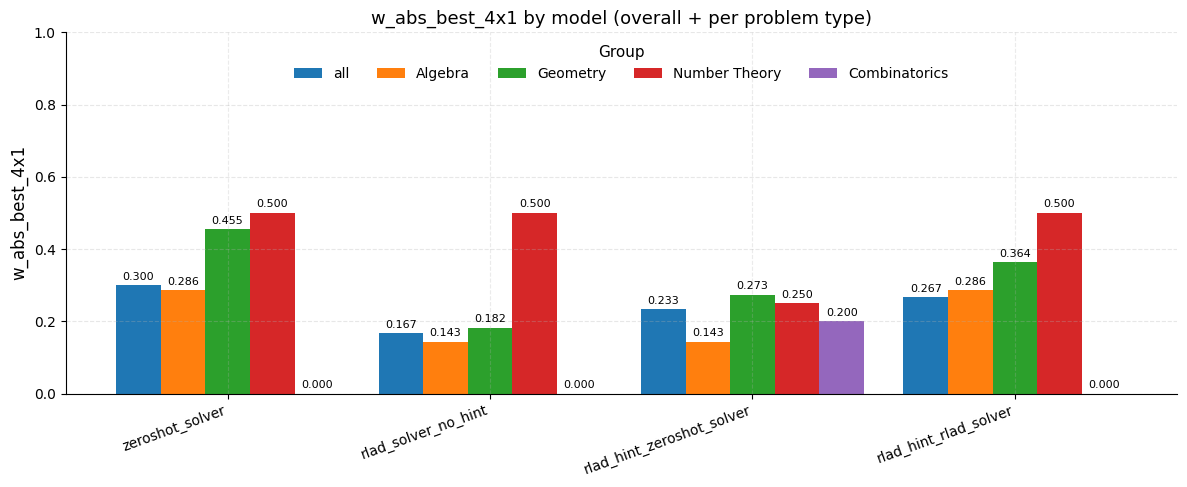

In [100]:
models = list(results["results"].keys())
# Collect problem types (assumes consistent across pipelines)
problem_types = ["Algebra", "Geometry", "Number Theory", "Combinatorics"]
groups = ["all"] + problem_types  # overall + per type

def extract_metric(model_name: str, group_name: str, metric_key: str) -> float:
    if group_name == "all":
        return results["results"][model_name]["all"][metric_key]
    return results["results"][model_name]["by_problem_type"][group_name][metric_key]

def plot_grouped(metric_key: str, title: str):
    # Data matrix: rows=models, cols=groups
    data = np.array([
        [extract_metric(m, g, metric_key) for g in groups]
        for m in models
    ])

    x = np.arange(len(models))
    n_groups = len(groups)

    # Bar geometry: one "cluster" per model, many bars inside
    total_width = 0.85
    bar_w = total_width / n_groups
    offsets = (np.arange(n_groups) - (n_groups - 1) / 2) * bar_w

    plt.figure(figsize=(12, 5))
    for j, g in enumerate(groups):
        plt.bar(x + offsets[j], data[:, j], width=bar_w, label=g)

        # annotate values
        for i in range(len(models)):
            v = data[i, j]
            plt.text(x[i] + offsets[j], v + 0.01, f"{v:.3f}", ha="center", va="bottom", fontsize=8)

    plt.title(title)
    plt.ylabel(metric_key)
    plt.xticks(x, models, rotation=20, ha="right")
    plt.ylim(0.0, 1.0)
    plt.grid(True, axis="y", alpha=0.3)
    plt.legend(title="Group", loc="upper center", ncol=min(5, n_groups), frameon=False)
    plt.tight_layout()
    plt.savefig(f"../plots/hmmt25_{metric_key}_by_model.pdf", bbox_inches='tight')
    plt.show()

# Plot 1: avg
plot_grouped(
    metric_key="w_abs_avg_4x1",
    title="w_abs_avg_4x1 by model (overall + per problem type)"
)

# Plot 2: best
plot_grouped(
    metric_key="w_abs_best_4x1",
    title="w_abs_best_4x1 by model (overall + per problem type)"
)